In [1]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import numpy as np

from final_project import loader, builder, models, plots
from final_project.models import ModelENUM
from pathlib import Path
from sklearn.model_selection import train_test_split

In [3]:
df = loader.get_df(all_files=True)
df = df[df['Origin'] == 'BOS']
df = df[[
    'DistanceGroup',
    'DayofMonth',
    'Month',
    'Year',
    'Duplicate',
    'ArrDel15',
    'DistanceGroup',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'Operating_Airline',
    'Dest'
]]
df = builder.encodeFrame(df)

delay_df = df[df['ArrDel15'] > 0.5].sample(n=20000)
on_time_df = df[df['ArrDel15'] <= 0.5].sample(n=80000)
sample_df = pd.concat([delay_df, on_time_df], ignore_index=True)


x = sample_df.drop(columns=['ArrDel15'])
y = sample_df[['ArrDel15']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=150)

In [4]:
lr_pipeline = models.get_pipeline(ModelENUM.LR)
param_grid = [
    # models.get_lr_param(solver="lbfgs", penalty=["l2"], c_list=[1, 10], max_iter=[10000]),
    # models.get_lr_param(solver="liblinear", penalty=["l1", "l2"], c_list=[1, 10], max_iter=[10000]),
    # models.get_lr_param(solver="saga", penalty=["l2", "elasticnet"], c_list=[1, 10], max_iter=[10000]),
    # models.get_lr_param(solver="newton-cholesky", penalty=["l2"], c_list=[1, 10], max_iter=[10000]),
    # models.get_lr_param(penalty=["l1", "l2"], c_list=[.1, 1], max_iter=[500]),1e-2, 1e-1, 1e1
 #    # models.get_lr_param(solver="saga", penalty=["l2"], c_list=[.1]),
]
grid_search = models.get_grid_search_cv(
    pipeline=lr_pipeline, param_grid=param_grid, cv=3, n_jobs=30
)

In [5]:
logreg_model = grid_search.fit(x_train, y_train.to_numpy().ravel())

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 2/2] START lr__C=10, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky
[CV 1/3; 1/2] START lr__C=1, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky
[CV 2/3; 2/2] START lr__C=10, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky
[CV 2/3; 1/2] START lr__C=1, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky
[CV 3/3; 2/2] START lr__C=10, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky
[CV 3/3; 1/2] START lr__C=1, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky
[CV 1/3; 1/2] END lr__C=1, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky;, score=0.282 total time=   0.1s
[CV 1/3; 2/2] END lr__C=10, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky;, score=0.576 total time=   0.1s
[CV 2/3; 2/2] END lr__C=10, lr__max_iter=10000, lr__penalty=l2, lr__solver=newton-cholesky;, score=0.607 total time=   0.1s
[CV 2/3; 1/2] E

In [6]:
params = models.get_best_params(models.ModelENUM.LR, logreg_model)
results = models.analyze_model(logreg_model, x_test, x_train, y_test, y_train)
print(json.dumps(params, indent=2))
print(json.dumps(results, indent=2))
models.save_model(models.ModelENUM.LR, logreg_model)

{
  "solver": "newton-cholesky",
  "penalty": "l2",
  "C": 10
}
{
  "Test Accuracy": 0.6176961602671118,
  "Train Accuracy": 0.6298056155507559,
  "Precision": 1.0,
  "Recall": 0.4468599033816425,
  "F-Beta Score": 0.6176961602671118,
  "F1 Score": 0.6176961602671118
}


414


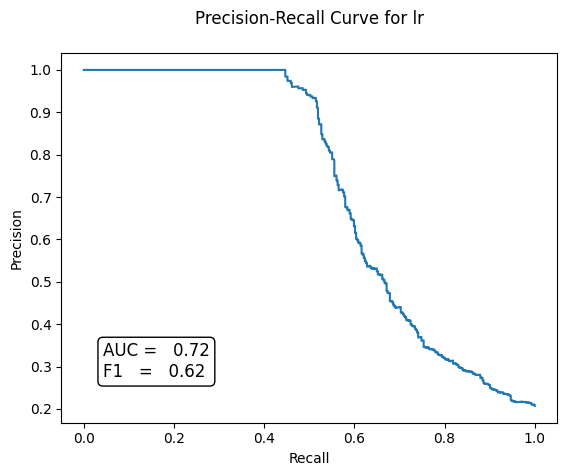

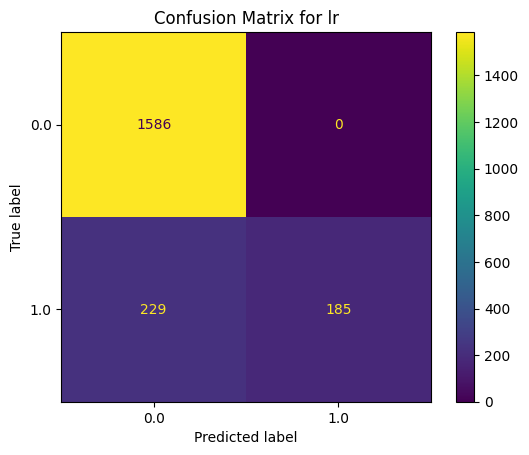

In [8]:
number_true = np.count_nonzero(y_test == 1)
print(number_true)

y_prob = logreg_model.predict_proba(x_test)[:, 1]
y_pred = logreg_model.predict(x_test)
plots.save_precision_recall_curve("lr", "test_file", y_test, y_prob)
plots.save_confusion_matrix("lr", "test_file", y_test, y_pred)